# Shelter Animal Outcomes

This notebook contains the analysis of the data from the Kaggle competition:
https://www.kaggle.com/c/shelter-animal-outcomes

I tested various classification algorithms and various methods for models explainability/feature importance such as permutation importance and shap values.

In [34]:
import csv
import string
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from numpy import *

from collections import Counter
from time import time

import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1)

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from catboost import CatBoostClassifier

In [2]:
path = '/Shelter_Animal/'

header_list = ['AnimalID','Name','DateTime','OutcomeType',
                  'OutcomeSubtype', 'AnimalType', 'Sex' , 'Age', 'Breed', 'Color']
                  
df = pd.read_csv(path + 'train.csv', delimiter=',', 
                          header=0, names = header_list)

df['DateTime'] = pd.to_datetime(df.DateTime)

In [3]:
print(df.shape)
df.head(5)

(26729, 10)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Sex,Age,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


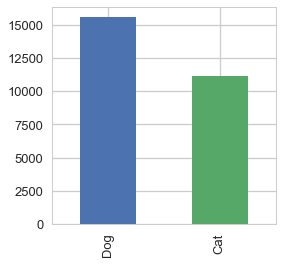

In [4]:
df['AnimalType'].value_counts().plot(kind="bar",figsize=(4,4))

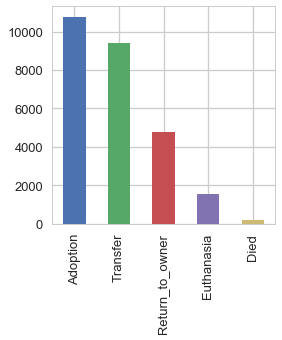

In [5]:
df['OutcomeType'].value_counts().plot(kind="bar",figsize=(4,4))

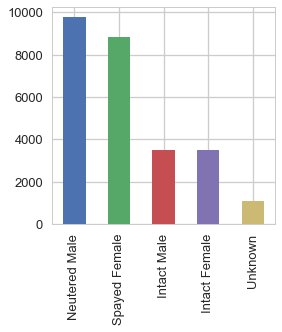

In [6]:
df['Sex'].value_counts().plot(kind="bar",figsize=(4,4))

In [7]:
df['AnimalType'] = df['AnimalType'].replace('Dog',1).replace('Cat',0)

In [8]:
df['Sex'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [9]:
df['Sex'] = df['Sex'].fillna(value='Unknown')

In [10]:
df['Age'].isnull().sum()

18

In [11]:
df = df[df['Age'].notnull()]
len(df['Age'].unique())

44

In [12]:
def age_to_days(age):
    day_week_month_year = age.split()[1][0]
    number = int(age.split()[0])
    if day_week_month_year == 'd':
        return number
    if day_week_month_year == 'w':
        return number*7
    elif day_week_month_year == 'm':
        return number*30
    elif day_week_month_year == 'y':
        return number*365

In [13]:
df['Age'] = df['Age'].apply(age_to_days)

In [14]:
df[df['Age'] == df['Age'].max()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Sex,Age,Breed,Color
13915,A693678,Kc,2014-12-13 16:38:00,Return_to_owner,NaN,0,Intact Female,7300,Domestic Shorthair Mix,Brown Tabby/White
20869,A672841,Camilla,2014-02-20 14:52:00,Transfer,Partner,0,Spayed Female,7300,Domestic Medium Hair Mix,Calico


Separate animals  that have a name from those that don't.

In [15]:
df['Name']
df['Name'][df['Name'].notnull()] = 1
df['Name'][df['Name'].isnull()] = 0

/Users/enricofonda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/enricofonda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


I tried various attempts to take into account the breed.
The first one is the following:

In [16]:
print(df['Breed'].unique())
print(len(df['Breed'].unique()))

['Shetland Sheepdog Mix' 'Domestic Shorthair Mix' 'Pit Bull Mix' ...
 'Vizsla/Boxer' 'German Shepherd/Australian Kelpie'
 'Boxer/German Shepherd']
1380


In [17]:
common_breeds = Counter(list(' '.join(df['Breed'].unique().tolist()).replace('/', ' ').split())).most_common(6)
list_breed_features = [x[0] for x in common_breeds]        

In [18]:
list_breed_features.remove('Mix')
list_breed_features

['Terrier', 'Retriever', 'Australian', 'Shepherd', 'Labrador']

In [25]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Sex,Age,Breed,Color,Mix
0,A671945,1,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,365,Other,Brown/White,1
1,A656520,1,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,365,Other,Cream Tabby,1
2,A686464,1,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,730,Other,Blue/White,1
3,A683430,0,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,21,Other,Blue Cream,1
4,A667013,0,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,730,Other,Tan,1


In [20]:
df['Mix'] = df['Breed']

In [21]:
def find_mix(breed):
    if ('/' in breed) or ('Mix' in breed):
        return 1
    else:
        return 0

In [22]:
df['Mix'] = df['Mix'].apply(find_mix)

In [23]:
def breed_summary(row):
    breed = row.replace('/', ' ').split()
    breed_counter = 0
    for breed_feat in list_breed_features:
        if breed_feat in breed:
            return breed_feat
            breed_counter += 1
    if breed_counter == 0:
        return 'Other'

In [24]:
df['Breed'] = df['Breed'].apply(breed_summary)

In [26]:
df_cat = df.copy()

In [27]:
df_cat.head(10)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Sex,Age,Breed,Color,Mix
0,A671945,1,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,365,Other,Brown/White,1
1,A656520,1,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,365,Other,Cream Tabby,1
2,A686464,1,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,730,Other,Blue/White,1
3,A683430,0,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,21,Other,Blue Cream,1
4,A667013,0,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,730,Other,Tan,1
5,A677334,1,2014-04-25 13:04:00,Transfer,Partner,1,Intact Female,30,Terrier,Black/Tan,1
6,A699218,1,2015-03-28 13:11:00,Transfer,Partner,0,Intact Male,21,Other,Blue Tabby,1
7,A701489,0,2015-04-30 17:02:00,Transfer,Partner,0,Unknown,21,Other,Brown Tabby,1
8,A671784,1,2014-02-04 17:17:00,Adoption,NaN,1,Spayed Female,150,Terrier,Red/White,1
9,A677747,0,2014-05-03 07:48:00,Adoption,Offsite,1,Spayed Female,365,Terrier,White,0


In [28]:
df_cat['Breed'].iloc[0]

'Other'

In [29]:
one_hot_sex = pd.get_dummies(df['Sex'])
df = df.join(one_hot_sex)
df = df.drop('Sex', 1)

In [30]:
one_hot_breed = pd.get_dummies(df['Breed'])
df = df.join(one_hot_breed)
df = df.drop('Breed', 1)

In [31]:
le = LabelEncoder()
labels = le.fit_transform(df['OutcomeType'])
print(list(le.classes_))

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']


In [32]:
df_cat = df_cat.drop(columns=['OutcomeType','OutcomeSubtype','Color', 'AnimalID','DateTime'])
df = df.drop(columns=['OutcomeType','OutcomeSubtype','Color', 'AnimalID','DateTime'])

In [33]:
df.head()

,Name,AnimalType,Age,Mix,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,Australian,Other,Retriever,Shepherd,Terrier
0,1,1,365,1,0,0,1,0,0,0,1,0,0,0
1,1,0,365,1,0,0,0,1,0,0,1,0,0,0
2,1,1,730,1,0,0,1,0,0,0,1,0,0,0
3,0,0,21,1,0,1,0,0,0,0,1,0,0,0
4,0,1,730,1,0,0,1,0,0,0,1,0,0,0


In [22]:
# features_train = df.as_matrix().astype(int)
# print(np.shape(features_train))

(26711, 13)


/Users/enricofonda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [42]:
# features_train = df
# print(np.shape(features_train))

(26711, 13)


In [52]:
df = df.astype(int)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.33, random_state=42)
print(np.shape(X_train))

(17896, 14)


In [54]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_cat, labels, test_size=0.33, random_state=42)

In [55]:
# features_test_cat = features_test_cat.fillna(value='Unknown')

In [56]:
scaler = MinMaxScaler(copy=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
%%time
clf = LogisticRegression()
clf.fit(X_train_scaled,y_train)
pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.631310266591038
CPU times: user 310 ms, sys: 30.6 ms, total: 340 ms
Wall time: 721 ms


/Users/enricofonda/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


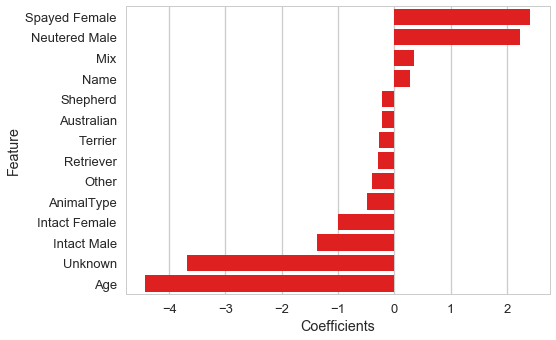

In [40]:
feat_imp = clf.coef_[0]
sorted_idx = np.argsort(-feat_imp)
feature_importance = pd.DataFrame(list(zip(df.columns[sorted_idx],feat_imp[sorted_idx])))
feature_importance = feature_importance.set_index(0)
f, ax = plt.subplots(1, figsize=(8,5))
sns.barplot(data=feature_importance.T, orient='h', color='red', ax=ax)
ax.set_xlabel('Coefficients')
ax.set_ylabel('Feature')
sns.set_style('whitegrid')
plt.tight_layout()

In [41]:
%%time
clf = LinearSVC(random_state=0)
clf.fit(X_train_scaled,y_train)
pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.6276800907543959
CPU times: user 1.32 s, sys: 28.3 ms, total: 1.35 s
Wall time: 1.62 s


In [42]:
%%time
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train_scaled,y_train)
pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.6268859897901304
CPU times: user 1.43 s, sys: 37.2 ms, total: 1.47 s
Wall time: 1.96 s


In [46]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6340328984685196
CPU times: user 219 ms, sys: 43.2 ms, total: 263 ms
Wall time: 425 ms


In [44]:
perm = PermutationImportance(clf, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = df.columns.tolist())

Weight,Feature
0.1410 ± 0.0074,Age
0.0943 ± 0.0036,Spayed Female
0.0823 ± 0.0032,Neutered Male
0.0632 ± 0.0034,AnimalType
0.0464 ± 0.0038,Name
0.0209 ± 0.0025,Intact Male
0.0207 ± 0.0021,Intact Female
0.0128 ± 0.0010,Mix
0.0064 ± 0.0010,Other
0.0043 ± 0.0019,Unknown


In [50]:
X_train = X_train.astype(int)

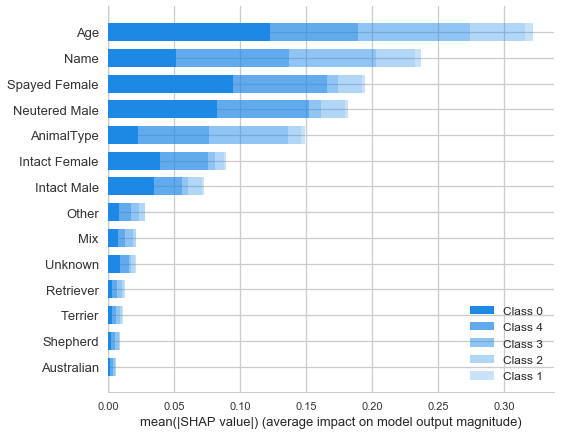

In [51]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train) 

In [57]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train_scaled,y_train)
pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6282473057288712
CPU times: user 160 ms, sys: 36.2 ms, total: 197 ms
Wall time: 316 ms


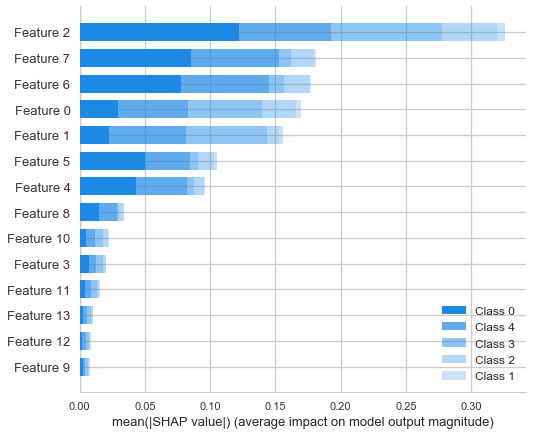

In [58]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled)

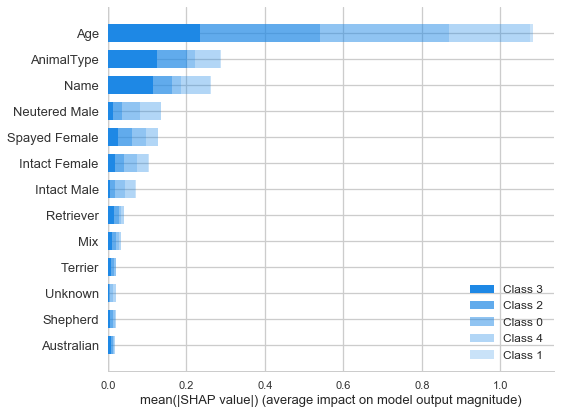

In [70]:
shap_values = shap.TreeExplainer(clf).shap_values(features_train)
shap.summary_plot(shap_values, features_train) 

In [59]:
%%time
clf = CatBoostClassifier(iterations=200,loss_function='MultiClass',verbose=False)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.650595575723199
CPU times: user 1min 15s, sys: 4.91 s, total: 1min 20s
Wall time: 43.5 s


/Users/enricofonda/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


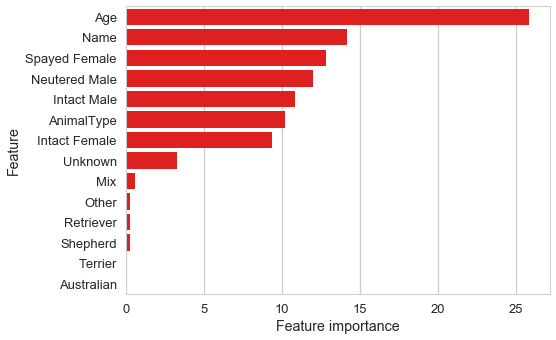

In [60]:
feat_imp = np.array(clf.get_feature_importance())
sorted_idx = np.argsort(-feat_imp)
feature_importance = pd.DataFrame(list(zip(df.columns[sorted_idx],feat_imp[sorted_idx])))
feature_importance = feature_importance.set_index(0)
f, ax = plt.subplots(1, figsize=(8,5))
# f, ax = plt.subplots(1)
sns.barplot(data=feature_importance.T, orient='h', color='red', ax=ax)
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')
sns.set_style('whitegrid')
plt.tight_layout()

In [62]:
perm = PermutationImportance(clf, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = df.columns.tolist())

Weight,Feature
0.0844 ± 0.0040,Age
0.0482 ± 0.0017,Spayed Female
0.0411 ± 0.0014,Neutered Male
0.0264 ± 0.0047,AnimalType
0.0257 ± 0.0031,Name
0.0254 ± 0.0040,Intact Male
0.0253 ± 0.0024,Intact Female
0.0029 ± 0.0012,Unknown
0.0016 ± 0.0010,Mix
0.0006 ± 0.0006,Other


In [84]:
params = {'depth': [4, 7, 10],
         'learning_rate' : [0.03, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [100],
          verbose=False}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, params, cv = 3)
cb_model.fit(features_train,labels_train)

0:	learn: 0.6751953	total: 66.5ms	remaining: 6.58s
1:	learn: 0.6571966	total: 419ms	remaining: 20.5s
2:	learn: 0.6424236	total: 464ms	remaining: 15s
3:	learn: 0.6290114	total: 503ms	remaining: 12.1s
4:	learn: 0.6173698	total: 559ms	remaining: 10.6s
5:	learn: 0.6064134	total: 576ms	remaining: 9.02s
6:	learn: 0.5960575	total: 592ms	remaining: 7.86s
7:	learn: 0.5865904	total: 609ms	remaining: 7s
8:	learn: 0.5780671	total: 643ms	remaining: 6.5s
9:	learn: 0.5690588	total: 699ms	remaining: 6.29s
10:	learn: 0.5618943	total: 719ms	remaining: 5.81s
11:	learn: 0.5552491	total: 736ms	remaining: 5.39s
12:	learn: 0.5491743	total: 756ms	remaining: 5.06s
13:	learn: 0.5417591	total: 774ms	remaining: 4.76s
14:	learn: 0.5365236	total: 792ms	remaining: 4.49s
15:	learn: 0.5327272	total: 809ms	remaining: 4.25s
16:	learn: 0.5302464	total: 828ms	remaining: 4.04s
17:	learn: 0.5263954	total: 845ms	remaining: 3.85s
18:	learn: 0.5228868	total: 908ms	remaining: 3.87s
19:	learn: 0.5194605	total: 924ms	remaining: 3

In [86]:
cb_model.best_params_

{'depth': 7, 'iterations': 100, 'l2_leaf_reg': 4, 'learning_rate': 0.15}

In [69]:
%%time
clf = CatBoostClassifier(iterations=200,loss_function='MultiClass',verbose=False, depth= 7, l2_leaf_reg= 4, learning_rate = 0.15)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.6494611457742484
CPU times: user 1min 21s, sys: 5.21 s, total: 1min 27s
Wall time: 39.7 s


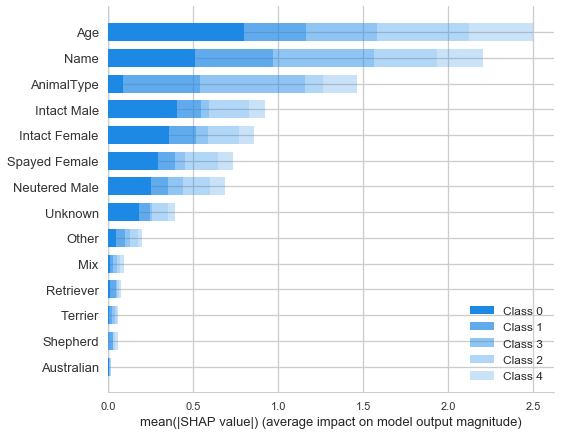

In [70]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train) 

In [72]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73      3548
           1       0.00      0.00      0.00        62
           2       0.59      0.14      0.22       498
           3       0.48      0.46      0.47      1583
           4       0.75      0.63      0.68      3124

   micro avg       0.65      0.65      0.65      8815
   macro avg       0.49      0.41      0.42      8815
weighted avg       0.65      0.65      0.63      8815



/Users/enricofonda/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
%%time
cat_features_index = [2,4]
clf = CatBoostClassifier(iterations=500,loss_function='MultiClass',verbose=False,one_hot_max_size=10)
clf.fit(X_train_cat,y_train,cat_features_index)

CPU times: user 3min 10s, sys: 12.1 s, total: 3min 22s
Wall time: 2min 49s


In [74]:
pred = clf.predict(X_test_cat)
print(accuracy_score(y_test, pred))

0.6528644356211004


/Users/enricofonda/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


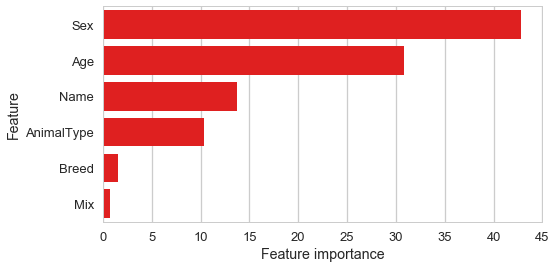

In [67]:
feat_imp = np.array(clf.get_feature_importance())
sorted_idx = np.argsort(-feat_imp)
feature_importance = pd.DataFrame(list(zip(df_cat.columns[sorted_idx],feat_imp[sorted_idx])))
feature_importance = feature_importance.set_index(0)
f, ax = plt.subplots(1, figsize=(8,4))
sns.barplot(data=feature_importance.T, orient='h', color='red', ax=ax)
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')
sns.set_style('whitegrid')
plt.tight_layout()

In [37]:
data_for_prediction = features_train_scaled[1,:].astype(float)  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [252]:

confusion_matrix(labels_test, pred)

array([[3044,    0,    0,  376,  128],
       [   2,    0,    1,    2,   57],
       [  87,    0,   48,  115,  248],
       [ 727,    0,    3,  706,  147],
       [ 908,    0,   22,  268, 1926]])

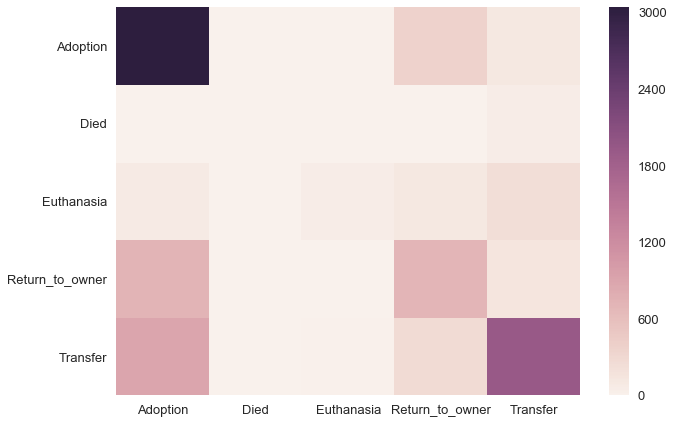

In [253]:
outcomes_names = list(le.classes_)
sns.heatmap(confusion_matrix(labels_test, pred), 
            xticklabels=outcomes_names,
            yticklabels=outcomes_names)

In [190]:

t0 = time()
#clf = OneVsRestClassifier(LinearSVC(random_state=0)) # 0.58
# clf = OneVsRestClassifier(RandomForestRegressor(n_estimators = 50)) # 0.63
# clf = AdaBoostClassifier(n_estimators=100) # 0.6325 - incuding breed 0.611
clf = LogisticRegression()
clf = CatBoostClassifier(iterations=10,loss_function='MultiClass') #verbose=False
clf.fit(features_train_scaled,labels_train)


print("done in %0.3fs" % (time() - t0))

0:	learn: -1.5669346	total: 244ms	remaining: 2.19s
1:	learn: -1.5249993	total: 384ms	remaining: 1.54s
2:	learn: -1.4891925	total: 649ms	remaining: 1.51s
3:	learn: -1.4567408	total: 790ms	remaining: 1.19s
4:	learn: -1.4262067	total: 914ms	remaining: 914ms
5:	learn: -1.3987071	total: 1.02s	remaining: 680ms
6:	learn: -1.3723493	total: 1.13s	remaining: 483ms
7:	learn: -1.3486023	total: 1.24s	remaining: 310ms
8:	learn: -1.3263651	total: 1.34s	remaining: 150ms
9:	learn: -1.3057151	total: 1.48s	remaining: 0us
done in 1.589s


In [198]:
pred = clf.predict(features_test_scaled)